<h2>Predict The News Category Hackathon</h2>

From the beginning, since the first printed newspaper, every news that makes into a page has had a specific section allotted to it. Although pretty much everything changed in newspapers from the ink to the type of paper used, this proper categorization of news was carried over by generations and even to the digital versions of the newspaper. Newspaper articles are not limited to a few topics or subjects, it covers a wide range of interests from politics to sports to movies and so on. For long, this process of sectioning was done manually by people but now technology can do it without much effort. In this hackathon, Data Science and Machine Learning enthusiasts like you will use Natural Language Processing to predict which genre or category a piece of news will fall in to from the story.<br/>

Size of training set: 7,628 records<br/>
Size of test set: 2,748 records<br/>

<b>FEATURES</b>:<br/>

<b>STORY</b>:  A part of the main content of the article to be published as a piece of news.<br/>
<b>SECTION</b>: The genre/category the STORY falls in.<br/>

There are four distinct sections where each story may fall in to. The Sections are labelled as follows :<br/>

Politics: 0 <br/>
Technology: 1 <br/>
Entertainment: 2 <br/>
Business: 3 <br/>

In [361]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import operator
import json
from xgboost import XGBClassifier
import re, string
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn.preprocessing import LabelEncoder, scale, PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, r2_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from pandas.plotting import scatter_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from datetime import datetime
from scipy import stats
from sklearn.svm import SVC
import torch.utils.data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from torch.autograd import Variable
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
#import cufflinks as cf

import warnings
warnings.filterwarnings('ignore')
nltk.download('punkt')
pd.set_option('display.max_columns', 500)

#init_notebook_mode(connected=True)
#cf.go_offline()

[nltk_data] Downloading package punkt to /home/koushik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [362]:
train_csv = pd.read_csv("Data_Train.csv", keep_default_na=False)
test_csv = pd.read_csv("Data_Test.csv", keep_default_na=False)

In [363]:
test_csv.shape

(2748, 1)

In [364]:
train_csv.shape

(7628, 2)

In [365]:
stemmer = PorterStemmer()

def beautifyAllText(x):
    if x != "":
        text = BeautifulSoup(x, "html.parser").get_text() # Remove HTML tags
        #text = text.lower().translate(str.maketrans('\n',' ',string.punctuation))
        text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
        words = text.split() # Split string into words
        words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
        words = [PorterStemmer().stem(w) for w in words] # stem
        return " ".join(words)
        return text
    return x

def preprocess_data(dataset):
    #dataset.sort_values("Review Text", inplace = True) 
    #dataset.drop_duplicates(subset ="Review Text", keep=False,inplace=False)
    #dataset = dataset.reset_index(drop=True)
    #dataset['Review Text'] = dataset["Review Title"].map(str) + " " + dataset['Review Text']
    dataset['STORY'] = dataset["STORY"].apply(beautifyAllText)
    #dataset = dataset.drop(['Review Title'],axis=1)
    return dataset

In [366]:
train = preprocess_data(train_csv.copy())
test = preprocess_data(test_csv.copy())

train_val = train[0:1000]

#train_X, test_X, train_y, test_y = train_test_split(train["Review Text"], train["topic"], random_state=33)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train), len(test)))
#s = " ".join(train["Review Text"][0:10])
train_csv.head()

IMDb reviews (combined): train = 7628, test = 2748


,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3


In [367]:
train_csv["STORY"][0]

'But the most painful was the huge reversal in fee income, unheard of among private sector lenders. Essentially, it means that Yes Bank took it for granted that fees on structured loan deals will be paid and accounted for upfront on its books. As borrowers turned defaulters, the fees tied to these loan deals fell off the cracks. Gill has now vowed to shift to a safer accounting practice of amortizing fee income rather than booking these upfront.\n\n\nGill’s move to mend past ways means that there will be no nasty surprises in the future. This is good news considering that investors love a clean image and loathe uncertainties.\n\n\nBut there is no gain without pain and the promise of a strong and stable balance sheet comes with some sacrifices as well. Investors will have to give up the hopes of phenomenal growth, a promise made by Kapoor.'

In [368]:
train["STORY"][0]

'pain huge revers fee incom unheard among privat sector lender essenti mean ye bank took grant fee structur loan deal paid account upfront book borrow turn default fee tie loan deal fell crack gill vow shift safer account practic amort fee incom rather book upfront gill move mend past way mean nasti surpris futur good news consid investor love clean imag loath uncertainti gain without pain promis strong stabl balanc sheet come sacrific well investor give hope phenomen growth promis made kapoor'

In [369]:
lens = train["STORY"].str.len()
lens.mean(), lens.std(), lens.max()

(408.6368641845831, 318.79337461128694, 3771)

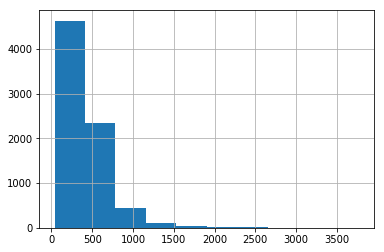

In [370]:
lens.hist();

In [371]:
train.groupby('SECTION').count()

,STORY
SECTION,
0,1686
1,2772
2,1924
3,1246


In [372]:
#train.groupby('topic').count()['Review Title'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8, title='Bar chart of Department Name', xTitle='Department Name')

In [373]:
#train_X.fillna("unknown", inplace=True)
#test_X.fillna("unknown", inplace=True)
#train_val["Review Text"].fillna("unknown", inplace=True)

In [374]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
#def tokenize(s): return re_tok.sub(r' \1 ', s).split()

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems


In [375]:
n = train.shape[0]


vec = TfidfVectorizer(ngram_range=(1,7), tokenizer=tokenize, stop_words='english')    
"""
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
"""

vec = vec.fit(pd.concat([train["STORY"], test["STORY"]], axis=0))

trn_term_doc = vec.transform(train["STORY"])
val_term_doc = vec.transform(train_val["STORY"])
test_term_doc = vec.transform(test["STORY"])

print(len(vec.get_feature_names()))

3048061


In [376]:
print(trn_term_doc.shape)
print(type(trn_term_doc))
#print(trn_term_doc)

(7628, 3048061)
<class 'scipy.sparse.csr.csr_matrix'>


In [377]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [378]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [ ]:
#final_preds = np.zeros((len(test), 4))
#print(preds.shape)

model = LogisticRegressionCV()
#model = SVC(class_weight=None)
#model = MultinomialNB()
#model = DecisionTreeClassifier(random_state=0)

train_y_label = list(train["SECTION"].values)
val_y_label = list(train_val["SECTION"].values)

model = model.fit(trn_term_doc, train_y_label)
train_score = model.score(trn_term_doc, train_y_label)
print(train_score)

test_score = model.score(val_term_doc, val_y_label)
print(test_score)


final_preds = model.predict(test_term_doc)
"""
for i, col in enumerate(label_cols):
    print('fit', col)
    m,r = get_mdl(binary_label[col])
    final_preds[:,i] = m.predict_proba(test_term.multiply(r))[:,1]

"""
print(final_preds)

In [ ]:
"""
final_preds = np.zeros((len(test_X), len(label_cols)))
print(final_preds.shape)

for i, col in enumerate(label_cols):
    print('fit', col)
    m,r = get_mdl(binary_label[col])
    final_preds[:,i] = m.predict_proba(test_term.multiply(r))[:,1]

#print(preds)

output = []
for row in final_preds:
    output.append(np.argmax(row))
print(output)
"""

In [ ]:
predictions = pd.DataFrame(pd.Series(final_preds), columns = ["SECTION"])
display(predictions.head())
predictions.to_csv('submission.csv', index=False)

In [ ]:
%reset